#### 1. Install and import required libraries
earthengine-api\
geemap\
geopandas\
pandas\
numpy\
scikit-learn\
matplotlib\
seaborn

In [1]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


#### 2. Initialize Google Earth Engine

In [2]:
project_id = 'bengaluru-lakes-485612'

try:
    ee.Initialize(project=project_id)
    print("Successfully initialized!")
except Exception:
    ee.Authenticate()
    ee.Initialize(project=project_id)

Successfully initialized!


#### 3. Define Bengaluru administrative boundary

In [3]:
bengaluru = (
    ee.FeatureCollection("FAO/GAUL/2015/level2")
    .filter(ee.Filter.eq("ADM2_NAME", "Bangalore Urban"))
)

Map = geemap.Map(center=[12.97, 77.59], zoom=10)
Map.addLayer(bengaluru, {}, "Bengaluru Boundary")
Map

Map(center=[12.97, 77.59], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

#### 4. Identify lakes using JRC Global Surface Water

In [4]:
# JRC Global Surface Water dataset
water_occurrence = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("occurrence")

# Permanent water bodies (>50% occurrence)
lakes = water_occurrence.gt(20).selfMask().clip(bengaluru)

Map.addLayer(lakes, {"palette": ["blue"]}, "Lakes")
Map

Map(center=[12.97, 77.59], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

Problems with this for Bengaluru lakes

Bellandur & Varthur are highly seasonal and polluted

Water extent fluctuates strongly year-to-year

Large parts of the lake:

Dry up seasonally

Are covered by hyacinth / algae

Appear spectrally similar to land

JRC marks such pixels as low occurrence, so they get excluded

➡️ Result:
Only the most persistent deep-water core is captured → exactly what your image shows.

This is expected behavior, not a coding bug.

Fetch lake boundaries from OpenStreetMap (Python)

In [5]:
import osmnx as ox
from shapely.geometry import box

# Define bounding box for Bengaluru
north, south, east, west = 13.2, 12.7, 77.9, 77.4
bbox = box(west, south, east, north)

tags = {"natural": "water"}

lakes_osm = ox.features_from_polygon(
    bbox,
    tags=tags
)

# Keep only polygon geometries
lakes_osm = lakes_osm[lakes_osm.geometry.type.isin(["Polygon", "MultiPolygon"])]

lakes_osm.head()


geometry emergency  \
element  id                                                                     
relation 1332093  POLYGON ((77.5791 13.07125, 77.57909 13.07121,...       NaN   
         1827922  POLYGON ((77.47331 12.7652, 77.47323 12.76516,...       NaN   
         1853330  POLYGON ((77.70218 13.01708, 77.70235 13.017, ...       NaN   
         1857615  POLYGON ((77.62261 12.98202, 77.6227 12.98193,...       NaN   
         2310400  POLYGON ((77.64527 13.02519, 77.64512 13.02543...       NaN   

                             name natural operator water        name:kn salt  \
element  id                                                                    
relation 1332093        NCBS Pond   water      NaN  pond            NaN  NaN   
         1827922              NaN   water      NaN   NaN            NaN  NaN   
         1853330  Vengayyana Lake   water      NaN   NaN  ವೆಂಗಯ್ಯನ ಕೆರೆ  NaN   
         1857615    Halasuru lake   water      NaN  lake    ಹಲಸೂರು ಕೆರೆ  NaN   
         2310400        Chelekere   water      NaN   NaN       ಚೇಳಿಕೆರೆ  NaN   

                 created_by golf  ... fixme seasonal was:landuse  \
element  id                       ...                              
relation 1332093        NaN  NaN  ...   NaN      NaN         NaN   
         1827922        NaN  NaN  ...   NaN      NaN         NaN   
         1853330        NaN  NaN  ...   NaN      NaN         NaN   
         1857615        NaN  NaN  ...   NaN      NaN         NaN   
         2310400        NaN  NaN  ...   NaN      NaN         NaN   

                          type name:de reservoir_type official_name:kn  \
element  id                                                              
relation 1332093  multipolygon     NaN            NaN              NaN   
         1827922  multipolygon     NaN            NaN              NaN   
         1853330  multipolygon     NaN            NaN              NaN   
         1857615  multipolygon     NaN            NaN              NaN   
         2310400  multipolygon     NaN            NaN              NaN   

                 wheelchair name:hi name:te  
element  id                                  
relation 1332093        NaN     NaN     NaN  
         1827922        NaN     NaN     NaN  
         1853330        NaN     NaN     NaN  
         1857615        NaN     NaN     NaN  
         2310400        NaN     NaN     NaN  

[5 rows x 58 columns]

#### 5. Remove ponds & tiny tanks

In [6]:
# Project to UTM for correct area calculation
lakes_osm = lakes_osm.to_crs(epsg=32643)

# Calculate area (sq meters)
lakes_osm["area_sqm"] = lakes_osm.geometry.area

# Keep lakes larger than 5 hectares
lakes_osm = lakes_osm[lakes_osm["area_sqm"] > 50_000]

# Back to WGS84
lakes_osm = lakes_osm.to_crs(epsg=4326)

lakes_osm.reset_index(drop=True, inplace=True)


#### 6. Verify with visuals

In [7]:
Map = geemap.Map(center=[12.97, 77.59], zoom=11)
Map.add_gdf(lakes_osm, layer_name="OSM Lakes", style={"color": "cyan", "fillColor": "blue"})
Map

Map(center=[12.97, 77.59], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

#### 7. Upload OSM lakes to Earth Engine

In [8]:
# Convert GeoDataFrame to EE FeatureCollection
lakes_ee = geemap.geopandas_to_ee(lakes_osm)

#### 8. Hyacinth water mask

In [20]:
def extract_water_robust(img):
    green = img.select("B3")
    nir   = img.select("B8")
    swir  = img.select("B11")

    # Indices
    ndwi  = green.subtract(nir).divide(green.add(nir))
    mndwi = green.subtract(swir).divide(green.add(swir))
    ndvi  = nir.subtract(green).divide(nir.add(green))

    # Open water
    open_water = mndwi.gt(0.15)

    # Hyacinth-covered water
    hyacinth = (
        ndvi.gt(0.25)
        .And(ndvi.lt(0.6))
        .And(swir.lt(1500))
    )

    # Final water mask
    water = open_water.Or(hyacinth)

    return water.selfMask()


#### 9. Identify named lakes

In [10]:
# Inspect lake names
lakes_ee.aggregate_array("name").getInfo()

# If names are missing, we assign manually


['Vengayyana Lake',
 'Halasuru lake',
 'Madiwala Lake',
 'Benniganahalli Lake',
 'Anchepalya Lake',
 'Sankey Tank',
 'Rachenahalli Lake',
 'Herohalli Kere',
 'Kommagatta Lake',
 'Kaikondrahalli Lake',
 'Lal Bahadur Shastri Nagar Lake',
 'Agara Lake',
 'Hebbal Lake',
 'Sarakki Kere',
 'Jakkur Lake',
 'Seegehalli Lake',
 'Yelahanka Lake',
 'Hemmigepura Kere',
 'Thubarahalli Lake',
 'Gulimangala Lake',
 'Kitthiganahalli Bommasandra Lake',
 'Puttenahalli Lake',
 'Attur Lake',
 'Allalasandra Lake',
 'Kodigehalli Lake',
 'Dasarahalli Tank',
 'Thimmasandra',
 'Doddakannelli Lake',
 'Kannuru Lake',
 'Kannuru Lake',
 'Kalkere Lake',
 'Horamavu Agara Lake',
 'Mahadevapura Lake',
 'Doddathogur Lake',
 'Kaggadasapura Lake',
 'Doddabommasandra Kere',
 'Varthur Lake',
 'Varthur Lake',
 'Ramapura Kere',
 'Kammasandra Lake',
 'Kammasandra Lake',
 'Choodasandra Lake',
 'Begur Lake',
 'Arekere lake',
 'Heelalige Lake',
 'Bellandur Lake',
 'Bellandur Lake',
 'Hulimavu Lake',
 'Gottigere Tank',
 'Chikka B

#### Filter Bellandur & Varthur

In [11]:
bellandur = lakes_ee.filter(ee.Filter.stringContains("name", "Bellandur"))
varthur   = lakes_ee.filter(ee.Filter.stringContains("name", "Varthur"))

#### Lake-wise annual area

In [12]:
def get_annual_s2(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end   = ee.Date.fromYMD(year, 12, 31)

    # 🔑 Client-side dataset switch
    if year < 2017:
        s2 = ee.ImageCollection("COPERNICUS/S2")
    else:
        s2 = ee.ImageCollection("COPERNICUS/S2_SR")

    s2 = (
        s2.filterDate(start, end)
          .filterBounds(bengaluru)
          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 40))
          .select(["B3", "B8", "B11"])
    )

    # Safety check for empty years
    return ee.Image(
        ee.Algorithms.If(
            s2.size().gt(0),
            s2.median(),
            ee.Image.constant([0, 0, 0]).rename(["B3", "B8", "B11"])
        )
    )


#### Lake time-series

In [13]:
def lake_area_timeseries(lake_fc, lake_name):
    records = []

    for year in range(2015, 2026):
        img = get_annual_s2(year)

        water = extract_water_robust(img).clip(lake_fc)

        # Explicit band name
        area_img = (
            water
            .multiply(ee.Image.pixelArea())
            .rename("water_area")
        )

        stats = area_img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=lake_fc.geometry(),
            scale=10,
            maxPixels=1e13
        )

        area_m2 = ee.Number(stats.get("water_area"))
        area_km2 = area_m2.divide(1e6)

        records.append({
            "lake": lake_name,
            "year": year,
            "area_km2": area_km2
        })

    return ee.FeatureCollection([
        ee.Feature(None, r) for r in records
    ]).getInfo()


In [15]:
for y in range(2015, 2026):
    img = get_annual_s2(y)
    print(
        y,
        img.bandNames().getInfo(),
        img.reduceRegion(
            ee.Reducer.mean(),
            bengaluru,
            20,
            maxPixels=1e13
        ).getInfo()
    )

2015 ['B3', 'B8', 'B11'] {'B11': 2282.405593413248, 'B3': 1171.4487189698086, 'B8': 2575.163271616366}
2016 ['B3', 'B8', 'B11'] {'B11': 2589.9478758239543, 'B3': 1245.9830576707934, 'B8': 2394.992428264107}
2017 ['B3', 'B8', 'B11'] {'B11': 3929.0829049149816, 'B3': 2021.7380272092014, 'B8': 3367.899614877714}
2018 ['B3', 'B8', 'B11'] {'B11': 3299.4135276952484, 'B3': 1637.313016780267, 'B8': 2914.01873210166}
2019 ['B3', 'B8', 'B11'] {'B11': 3156.538328082887, 'B3': 1286.532411721801, 'B8': 2695.333175833826}
2020 ['B3', 'B8', 'B11'] {'B11': 2932.9067566319877, 'B3': 1148.8833473004825, 'B8': 2574.7109204465114}
2021 ['B3', 'B8', 'B11'] {'B11': 2889.846832755572, 'B3': 1114.7534401768887, 'B8': 2572.455310630532}
2022 ['B3', 'B8', 'B11'] {'B11': 3748.5458705987908, 'B3': 2059.228856210376, 'B8': 3514.381096358704}
2023 ['B3', 'B8', 'B11'] {'B11': 3715.996601293514, 'B3': 2056.482762261038, 'B8': 3553.187476928618}
2024 ['B3', 'B8', 'B11'] {'B11': 3997.9438619632892, 'B3': 2187.70701689

#### Generate time series

In [21]:
df_bellandur = lake_area_timeseries(bellandur, "Bellandur")
df_varthur   = lake_area_timeseries(varthur, "Varthur")


#### Convert to pandas & inspect

In [22]:
bell = pd.DataFrame([f["properties"] for f in df_bellandur["features"]])
var  = pd.DataFrame([f["properties"] for f in df_varthur["features"]])

bell, var

(    area_km2       lake  year
 0   1.400230  Bellandur  2015
 1   1.466069  Bellandur  2016
 2   0.641684  Bellandur  2017
 3   0.995882  Bellandur  2018
 4   0.245792  Bellandur  2019
 5   0.381519  Bellandur  2020
 6   0.030903  Bellandur  2021
 7   0.000097  Bellandur  2022
 8   0.233468  Bellandur  2023
 9   0.010172  Bellandur  2024
 10  0.154710  Bellandur  2025,
     area_km2     lake  year
 0   1.061223  Varthur  2015
 1   0.838405  Varthur  2016
 2   0.004553  Varthur  2017
 3   0.457481  Varthur  2018
 4   0.096708  Varthur  2019
 5   0.098903  Varthur  2020
 6   0.000000  Varthur  2021
 7   0.000000  Varthur  2022
 8   0.002422  Varthur  2023
 9   0.000097  Varthur  2024
 10  0.000581  Varthur  2025)

#### Quick diagnostic plot

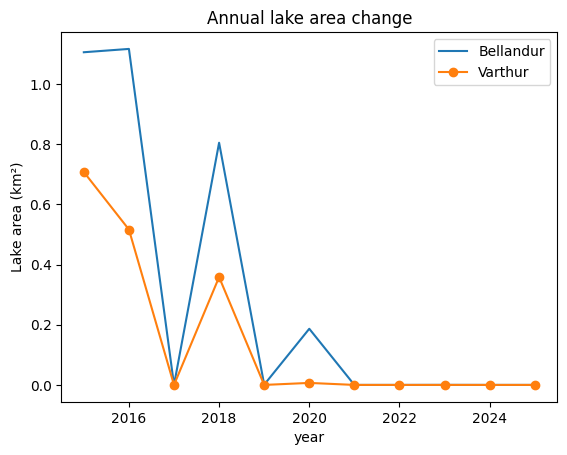

In [19]:
bell.set_index("year")["area_km2"].plot(label="Bellandur")
var.set_index("year")["area_km2"].plot(label="Varthur", marker="o")
plt.legend()
plt.ylabel("Lake area (km²)")
plt.title("Annual lake area change")
plt.show()
